First, we load up some useful libraries for visualization and data structures.

In [9]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random

try:
    import Queue as Q
except ImportError:
    import queue as Q

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


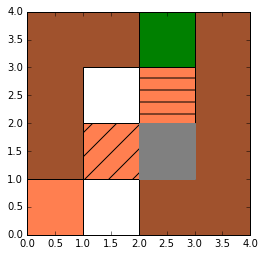

In [23]:
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric()
        )
    
    def __comp__ (self, other):
        if self == other:
            return []
        return __cmp__(id(self), id(other))
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def available_moves_from_point(self, point):
        if not self.player_alive:
            return[]
        (x,y) = point
        
        valid_set = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        ret_val = []
        for (dx, dy) in valid_set:
            if self.is_free(x+dx, y+dy):
                ret_val.append((dx, dy))
        return ret_val
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)
        
    def __eq__(self,other):
        return self.grid == other.grid and self.player_pos == other.player_pos and self.player_alive == other.player_alive
    
    def __neq__(self,other):
        return not self == other
    
    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def __cmp__(self,other):
        if self == other:
            return 0
        return __cmp__(id(self), id(other))

sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
sample.move_player(1,0)
sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

In [24]:
def manhattan_distance(point_a, point_b):
    (x0, y0) = point_a
    (x1, y1) = point_b
    return (abs(x1-x0)) + (abs(y1-y0))

def reconstruct_path(came_from, start, goal):
    (x, y) = goal
    goal = (x, y-1)
        
    current = goal
    path = [current]
    if not goal in came_from:
        print("It hasn't gone through the goal. It's unsolvable.")
        return
    while current != start:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path
    
def element_wise_tuple_addition(x,y): #adding tuples
    z = []
    for i in range(len(x)):
        z.append(x[i] + y[i])
    return tuple(z)

def heuristic(maze):
    
    # Return a path which solves the maze: a sequence of elements like (dx,dy) or "switch".
    # You can use maze.exit_pos and query maze.grid[row][column] to investigate the maze.
    
    frontier = Q.PriorityQueue() #creating priority queue
    start = maze.player_pos
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    
    while not frontier.empty():
        current = frontier.get()[1]
        
        if current == maze.exit_pos:
            break
        
        for possible_move in maze.available_moves_from_point(current):
            next_move = (current[0] + possible_move[0], current[1] + possible_move[1])
            if next_move != "switch":
                new_cost = cost_so_far[current] + 1
                if next_move not in cost_so_far or new_cost < cost_so_far[next_move]:
                    cost_so_far[next_move] = new_cost
                    priority = new_cost + manhattan_distance(maze.exit_pos, next_move)
                    frontier.put((priority, next_move))
                    came_from[next_move] = current
                    
    return reconstruct_path(came_from, maze.player_pos, maze.exit_pos)

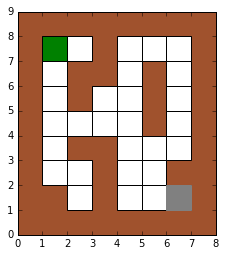

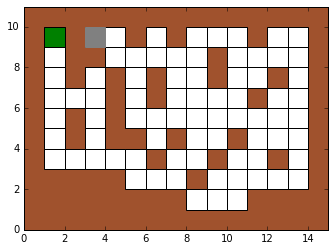

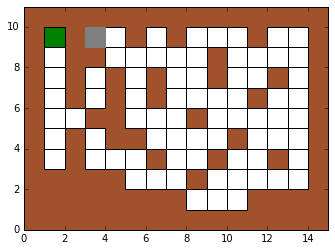

In [21]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

mazeUnsolvable1().draw()

In [25]:
print(heuristic(maze1()))
print(heuristic(maze2()))
print(heuristic(mazeUnsolvable1()))

[(6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (1, 5), (1, 6)]
[(3, 9), (4, 9), (4, 8), (5, 8), (5, 7), (5, 6), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (7, 3), (7, 2), (6, 2), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8)]
It hasn't gone through the goal. It's unsolvable.
None


You also have to be able to handle switch and door puzzles:

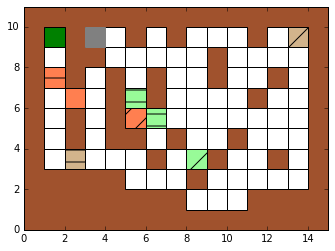

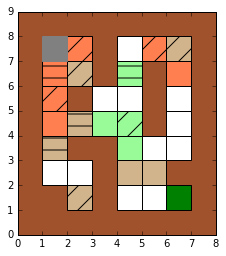

In [237]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

In [238]:
print(heuristic(maze3()))
print(heuristic(maze4()))

[]
[]


# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [239]:
class TreeNode:
    def __init__(self, val):
        self.value = val
        self.children = []
        self.parent = None
    def add_child(self, tn):
        self.children.append(tn)
        tn.parent = self

def mcts(maze,iterations):
    # Return the expected value (a number between 0 for "player dead", 1 for "made it to the end")
    # for a budget of `iterations` rollouts.
    # Should also return the best found path (the one most likely to lead to success).
    # Here, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` rollouts, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([], 0)

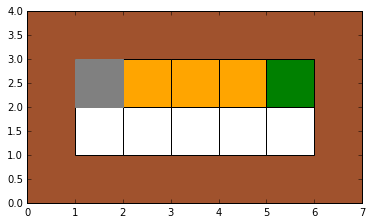

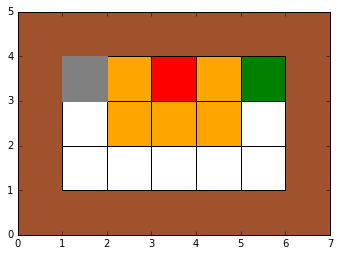

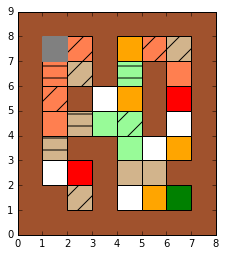

In [240]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [241]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)

# Bonus Assignment

Make an adversary for the maze who is trying to eat the player. Try to get the best performing adversary possible!